# Regression Models with Pycaret

#### Get information

In [1]:
from pycaret.regression import *

In [2]:
# load the dataset from pycaret
from pycaret.datasets import get_data
dataset = get_data('diamond')


,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


In [35]:
#Save the data in csv file format
dataset.to_csv('diamond_dataset.csv', index=False)

#### EDA

In [1]:
#!pip install ydata-profiling
#or use 
#pip install pycaret[analysis]

In [4]:
dataset = get_data('diamond', profile=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (5400, 8)
Unseen Data For Predictions (600, 8)


#### Preprocessing

In [6]:
from pycaret.regression import setup
help(setup)

Help on function setup in module pycaret.regression.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Optional[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]]] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Optional[Dict[str, list]] = None, numeric_features: Optional[List[str]] = None, categorical_features: Optional[List[str]] = None, date_features: Optional[List[str]] = None, text_features: Optional[List[str]] = None, ignore_features: Optional[List[str]] = None, keep_features: Optional[List[str]] = None, preprocess: boo

# To Run Experiments using setup() function of pycaret, requires installation of mlflow

In [2]:
#Installing mlflow 
#!pip install mlflow

In [8]:
import mlflow

# Set MLflow tracking URI to a directory that exists
mlflow.set_tracking_uri('file:///C:/Users/jalal/OneDrive/Desktop/jjj/2_Automating the ML Model Cycle/mlruns1')


In [9]:
# initialize setup

exp_reg102 = setup(data = data, target = 'Price', 
                   session_id=123,
                   normalize = True, 
                   transformation = True, transform_target = True, 
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
                  bin_numeric_features = ['Carat Weight'],
                  log_experiment = True, experiment_name = 'diamond1') 

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(5400, 8)"
4,Transformed data shape,"(5400, 28)"
5,Transformed train set shape,"(3779, 28)"
6,Transformed test set shape,"(1621, 28)"
7,Ordinal features,1
8,Numeric features,1
9,Categorical features,6


#### Model Training

In [10]:
best_model = compare_models(exclude = ['ransac'])
'''
'ransac' refers to the RANSAC (RANdom SAmple Consensus) algorithm. 
RANSAC is an iterative method to estimate parameters of a mathematical model from a set of observed data 
which contains outliers. It's particularly popular in the field of computer vision.
'''

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1707.9544,5903344.1271,2417.2365,0.9413,0.2225,0.1887,0.2550
lightgbm,Light Gradient Boosting Machine,1660.9066,6358156.8678,2495.2445,0.9377,0.2235,0.1842,0.2700
rf,Random Forest Regressor,1741.3787,7137302.0316,2652.7687,0.9301,0.2402,0.1914,0.4860
et,Extra Trees Regressor,1899.5518,8861962.0801,2964.1057,0.9123,0.2605,0.2042,0.4920
dt,Decision Tree Regressor,1917.2621,9348381.9398,3041.8356,0.9078,0.2611,0.2045,0.1450
huber,Huber Regressor,2459.0362,13448255.5674,3652.8315,0.8665,0.2773,0.2450,0.1500
ridge,Ridge Regression,2525.0260,13756677.4502,3694.6290,0.8634,0.2745,0.2399,0.1340
br,Bayesian Ridge,2528.8946,13826571.1684,3703.9075,0.8627,0.2745,0.2399,0.1790
lr,Linear Regression,2535.6696,14052864.6395,3731.8837,0.8606,0.2750,0.2402,1.1560
ada,AdaBoost Regressor,2708.1303,25054664.8993,4936.7017,0.7588,0.2920,0.2256,0.2580


"\n'ransac' refers to the RANSAC (RANdom SAmple Consensus) algorithm. \nRANSAC is an iterative method to estimate parameters of a mathematical model from a set of observed data \nwhich contains outliers. It's particularly popular in the field of computer vision.\n"

In [11]:
tuned_best = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1679.0225,5267570.3128,2295.1188,0.9422,0.2189,0.1822
1,1966.8693,12919474.9145,3594.3671,0.9010,0.2313,0.1945
2,1836.1748,7936481.8015,2817.1762,0.9272,0.2408,0.2054
3,1679.5022,5620524.0428,2370.7644,0.9380,0.2139,0.1786
4,1723.3571,5921593.8542,2433.4325,0.9261,0.2317,0.1982
5,1904.1648,13019205.0876,3608.2136,0.8889,0.2263,0.1933
6,1849.4508,8032177.3277,2834.1096,0.9245,0.2285,0.1930
7,1364.8422,4934572.8565,2221.3898,0.9376,0.1954,0.1531
8,1799.9373,7083354.7602,2661.4573,0.9304,0.2253,0.1871


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### Individual model training

In [12]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1631.2197,4764978.7229,2182.8831,0.9477,0.2273,0.1848
1,1786.1408,8517522.8962,2918.4796,0.9347,0.2257,0.1875
2,1678.9553,5196108.3842,2279.4974,0.9523,0.2389,0.1997
3,1641.9054,4585709.6133,2141.4270,0.9494,0.2129,0.1765
4,1669.5466,6287592.8249,2507.5073,0.9216,0.2293,0.1919
5,1739.9398,8399345.6706,2898.1625,0.9283,0.2197,0.1862
6,1846.1307,8981458.3319,2996.9081,0.9156,0.2294,0.1871
7,1254.5156,3385188.9328,1839.8883,0.9572,0.1903,0.1479
8,1651.8998,6412245.8029,2532.2413,0.9370,0.2195,0.1779


In [13]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }

tuned_lightgbm = tune_model(lightgbm, 
                            custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1675.2714,5086398.1446,2255.3044,0.9442,0.2344,0.1883
1,1795.2791,8215553.0369,2866.2786,0.9370,0.2363,0.1923
2,1838.7086,7425749.0618,2725.0228,0.9319,0.2468,0.2060
3,1674.8863,5123457.3518,2263.5055,0.9435,0.2180,0.1780
4,1700.3237,6162104.8259,2482.3587,0.9231,0.2358,0.1948
5,1748.1738,8683121.7790,2946.7137,0.9259,0.2272,0.1892
6,1926.7462,10303603.5644,3209.9227,0.9032,0.2382,0.1893
7,1331.8388,4013445.1362,2003.3585,0.9492,0.1965,0.1521
8,1716.2054,6753901.5664,2598.8270,0.9337,0.2287,0.1845


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Evaluate model

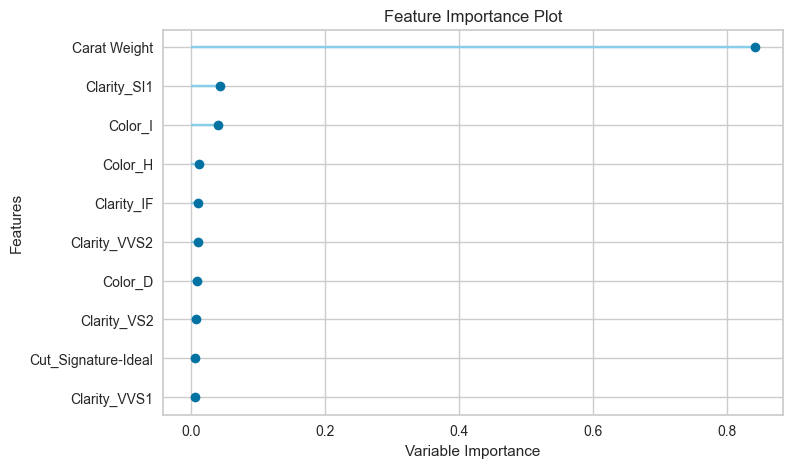

In [15]:
# check feature importance
plot_model(tuned_best, plot = 'feature')

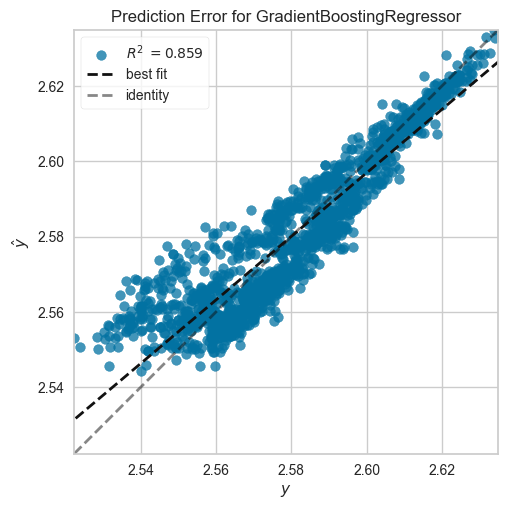

In [16]:
plot_model(tuned_best, plot = 'error')

In [17]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate model with test data

Before finalizing the model, it is recommended to perform a final check by predicting the test set and reviewing the evaluation metrics. All of the evaluation metrics we've seen above are cross-validated results based **only on the training set (70%)**. Now, we are going to use the test data to see if the performance is different and there may be overfitting.

In [18]:
predict_model(tuned_best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1760.3773,6164870.2398,2482.9157,0.9438,0.2237,0.1886


### Finish to put into production

In [19]:
# finalize the model
final_best = finalize_model(tuned_best)

# save model to disk
save_model(final_best, 'diamond-pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Carat Weight'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Cut', 'Color', 'Clarity',
                                              'P...
                                     transformer=KBinsDiscretizer(encode='ordinal',
                                                                  strategy='kmeans'))),
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('clean_column_names',
                  TransformerWrappe

### Predictions with unseen data

In [29]:
#Creating a dataset
import pandas as pd

# Sample unseen data for prediction
data_unseen = pd.DataFrame({
    'Carat Weight': [1.05, 0.76, 0.82, 0.95, 0.78],  # Example carat weights
    'Cut': ['Ideal', 'Very Good', 'Ideal', 'Good', 'Very Good'],  # Example cuts
    'Color': ['H', 'E', 'G', 'F', 'H'],  # Example colors
    'Clarity': ['SI1', 'VS2', 'SI1', 'VS1', 'SI2'],  # Example clarities
    'Polish': ['VG', 'EX', 'VG', 'VG', 'EX'],  # Example polishes
    'Symmetry': ['EX', 'VG', 'EX', 'G', 'VG'],  # Example symmetries
    'Report': ['GIA', 'GIA', 'AGSL', 'GIA', 'AGSL']  # Example reports
})

# Adding an example 'Actual_Price' column to the data_unseen DataFrame
data_unseen['Actual_Price'] = [5000, 3500, 4000, 4500, 3700]  # Example actual prices


In [30]:
# Assuming final_best is your trained model from PyCaret
predictions = predict_model(final_best, data=data_unseen.drop(columns=['Actual_Price']))

In [31]:
print(unseen_predictions.columns)

Index(['Carat Weight', 'Cut', 'Color', 'Clarity', 'Polish', 'Symmetry',
       'Report', 'prediction_label'],
      dtype='object')


In [33]:
# Adding the predictions to the original DataFrame
data_unseen['Predicted_Price'] = predictions['prediction_label']

# Calculate R-squared value
r2 = r2_score(data_unseen['Actual_Price'], data_unseen['Predicted_Price'])
print("R-squared (R²):", r2)

# Display actual and predicted prices
print(data_unseen[['Actual_Price', 'Predicted_Price']])

R-squared (R²): -5.210483302014272
   Actual_Price  Predicted_Price
0          5000      4379.607671
1          3500      5711.881865
2          4000      4184.156956
3          4500      5945.092078
4          3700      5066.209414
